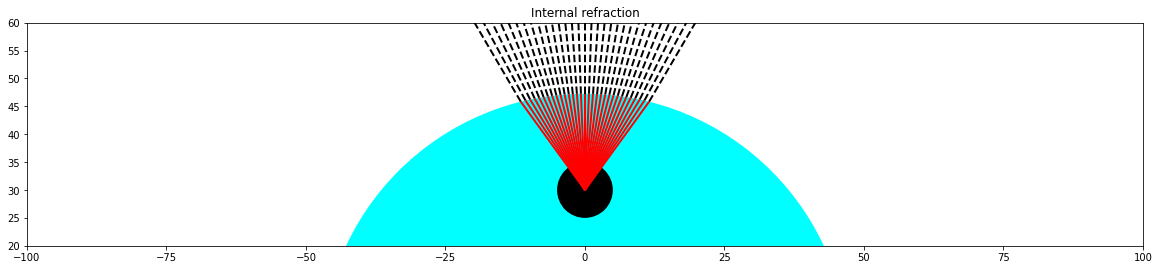

In [12]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib.collections as collections
import numpy as np
from numpy import linalg
import math

class Params:
    rad_to_degree = math.pi / 180.0
    water_refractive_index = 1.333
    dome_thickness_mm = 3.75
    acrylic_refractive_index = 1.495
    dome_external_radius = 43.5 + 3.75
    field_of_view_degrees = 72.0
    field_of_view_rads = field_of_view_degrees * rad_to_degree
    nrays_to_show = 30 
    nodal_y_offset = 30.0
    nodal_point_location = np.array([0.0, nodal_y_offset])
    
    internal_refraction_visualized = True
    
    
def quadratic_formula(a, b, c):
    x1 = (-b + math.sqrt(math.pow(b, 2) - 4*a*c)) / (2*a)
    x2 = (-b - math.sqrt(math.pow(b, 2) - 4*a*c)) / (2*a)
    
    return x1, x2


def get_ray_circle_intersection(ray_base_point, ray_direction, circle_radius):
    dx = ray_direction[0]
    dy = ray_direction[1]
    
    px = ray_base_point[0]
    py = ray_base_point[1]
    
    r = circle_radius
    
    a = math.pow(dx, 2) + math.pow(dy, 2)
    b = 2*px*dx + 2*py*dy
    c = math.pow(px, 2) + math.pow(py, 2) - math.pow(r, 2)
    
    s1, s2 = quadratic_formula(a, b, c)
    
    s = None
    if s1 > 0 and s2 > 0:
        s = min(s1, s2)
    elif s1 > 0:
        s = s1
    elif s2 > 0:
        s = s2
    else:
        raise Exception("blarg")
        
    intersection_point = ray_base_point + s * ray_direction

    return intersection_point


def get_intermediates(start_angle, end_angle, n_total):
    step = (end_angle - start_angle) / float(n_total)
    angles = [start_angle]
    
    for i in range(n_total-1):
        angles.append(start_angle + float(i+1) * step)
    
    angles.append(end_angle)
    return angles

def get_direction(angle):
    direction = np.array([
        math.cos((math.pi/2.0) + (angle * Params.rad_to_degree)),
        math.sin((math.pi/2.0) + (angle * Params.rad_to_degree))
    ])
    
    return direction


def get_rays_spanning_angles_from_point(start_angle, end_angle, base_point, nrays):
    ray_angles = get_intermediates(start_angle, end_angle, nrays)
    ray_directions = [get_direction(a) for a in ray_angles]
    
    return [
        (base_point, ray_direction) for ray_direction in ray_directions
    ]


def get_internal_rays_from_nodal_point(nodal_point_location):
    angle_step = Params.field_of_view_degrees / (Params.nrays_to_show - 1)
    first_ray_angle = -Params.field_of_view_degrees / 2.0
    ray_angles = [
        first_ray_angle
    ]

    internal_rays = []
    rays = get_rays_spanning_angles_from_point(first_ray_angle, -first_ray_angle, nodal_point_location, Params.nrays_to_show)

    for base_point, ray_direction in rays:
        ray_endpoint = get_ray_circle_intersection(base_point, ray_direction, Params.dome_external_radius)
        internal_rays.append(
           (nodal_point_location, ray_endpoint) 
        )
        
    return internal_rays


def get_angle_between_vectors(v1, v2):
    try:
        #return math.acos(
        #    v1.dot(v2) / (linalg.norm(v1) * linalg.norm(v2))
        #)
    
        x1, y1 = v1
        x2, y2 = v2
        a = math.atan2(x1*y2-y1*x2,x1*x2+y1*y2)
        
        return a
    except Exception as e:
        return 0.0
    
    
def get_dome_normal_at_point(point):
    dome_center = np.array([0.0, 0.0])
    return point / linalg.norm(point)


def rotate_vector(vector, angle):
    rotation_mat = np.array([
        [math.cos(angle), -math.sin(angle)],
        [math.sin(angle), math.cos(angle)]
    ])
    
    return rotation_mat.dot(vector)


def refract_ray(ray_base_point, ray_circle_intersection, ray_originates_inside):
    normal_at_intersection = get_dome_normal_at_point(ray_circle_intersection)
    
    if not ray_originates_inside:
        normal_at_intersection = -normal_at_intersection
    
    ray_direction = ray_circle_intersection - ray_base_point
    angle_of_incidence = get_angle_between_vectors(ray_direction, normal_at_intersection)
    
    n1 = None # first refraction index
    n2 = None # second refraction index
    if ray_originates_inside:
        n1 = 1
        n2 = Params.water_refractive_index
    else:
        n2 = 1
        n1 = Params.water_refractive_index
 
    refracted_angle = math.asin((n1 * math.sin(angle_of_incidence))/n2)
    
    if angle_of_incidence > 0 and refracted_angle > 0:
        refracted_angle = -refracted_angle
    if angle_of_incidence < 0 and refracted_angle < 0:
        refracted_angle = -refracted_angle
    
    refracted_direction = rotate_vector(normal_at_intersection, refracted_angle)
    
    if not ray_originates_inside:
        refracted_direction = refracted_direction
    
    return ray_circle_intersection, refracted_direction


def ray_to_segment(base_point, direction, length):
    return [base_point, base_point + (length * direction)]
    

def draw_dome_and_nodal_point(ax):
    dome_patch = patches.Circle(xy=(0.0, 0.0), radius=Params.dome_external_radius, fc=(0.0, 1.0, 1.0, 1.0))
    ax.add_patch(dome_patch)
    nodal_point = patches.Circle(xy=Params.nodal_point_location, radius=5.0, fc=(0.0,0.0,0.0,1.0))
    ax.add_patch(nodal_point)
    
    
def draw_segments(ax, segments, color, style, linewidth):
    colors = [color for _ in segments]
    lc = collections.LineCollection(segments, colors=colors, linewidths=linewidth, linestyle=style)
    ax.add_collection(lc)
    
    
def draw_dome_normals_at_points(points, length):
    normals = [get_dome_normal_at_point(p) for p in points]
    segments = [
        ray_to_segment(p, n, length) for p, n in zip(points, normals)
    ] + [
        ray_to_segment(p, n, -length) for p, n in zip(points, normals)
    ]
    colors = [[1.0, 0.0, 1.0, 1.0] for _ in segments]
    lc = collections.LineCollection(segments, colors=colors, linewidths=2, linestyle='--')
    ax.add_collection(lc)
    

fig, ax = plt.subplots(figsize=(20,20))

draw_dome_and_nodal_point(ax)

internal_rays = get_internal_rays_from_nodal_point(Params.nodal_point_location)
refracted_rays = []
for ray in internal_rays:
    length = 200.0
    ray_base, ray_dir = refract_ray(ray[0], ray[1], True)
    
    refracted_rays.append(
        [ray_base, ray_base + (length * ray_dir)]
    )
    
draw_segments(ax=ax, segments=refracted_rays, color=[0.0, 0.0, 0.0, 1.0], style='--', linewidth=2)
draw_segments(ax=ax, segments=internal_rays, color=[1.0, 0.0, 0.0, 1.0], style='-', linewidth=2)
#draw_dome_normals_at_points([s[1] for s in internal_rays], 20)
 
ax.set_xlim((-100.0, 100.0))
ax.set_ylim((20.0, 60.0))
ax.set_title("Internal refraction")
ax.set_aspect('equal')

Distances
[132.7663946560454, 133.53618185682353, 134.1831705952526, 134.70959335571382, 135.11723279036084, 135.40744892797733, 135.58119937526567]
Min focal dist approx: 132.7663946560454


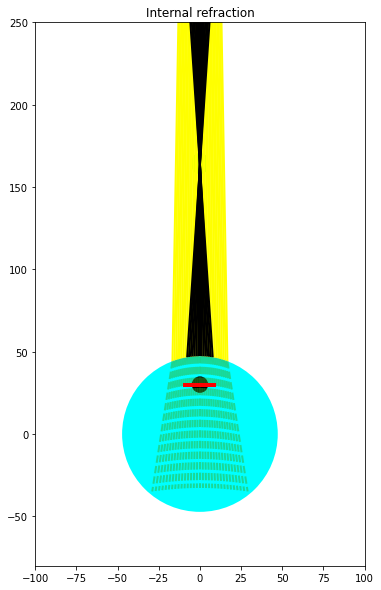

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
external_pt_distance = 1000.0

draw_dome_and_nodal_point(ax)

downward = 180.0
#width = 0.0000035
width = 2.0000035
import shapely
from shapely.geometry import LineString, Point

external_pt = np.array([0.0, external_pt_distance])
angle_span = [downward - width/2.0, downward + width/2.0]
external_pt_patch = patches.Circle(xy=external_pt, radius=3.0, fc=(0.0, 1.0, 1.0, 1.0))

def get_intersection_between_segs(segs):
    intersections = []
    for i in range(int(len(segs)/2)):
        s1 = segs[i]
        s2 = segs[len(segs)-i-1]
        
        l1 = LineString(s1)
        l2 = LineString(s2)
        
        p = l1.intersection(l2)
        
        try:
            intersections.append(np.array([p.x, p.y]))
        except:
            pass
        
    return intersections

ax.add_patch(external_pt_patch)
rays = get_rays_spanning_angles_from_point(angle_span[0], angle_span[1], external_pt, Params.nrays_to_show)

segments = [
    [ray[0], get_ray_circle_intersection(ray[0], ray[1], Params.dome_external_radius)] for ray in rays
]

aperture_dia = 20.0

aperture_line = [Params.nodal_point_location - np.array([aperture_dia / 2.0, 0.0]), Params.nodal_point_location + np.array([aperture_dia / 2.0, 0.0])]
ap = LineString(aperture_line)

refracted_segs = []
segs_for_intersection = []
for seg in segments:
    b, d = refract_ray(seg[0], seg[1], False)
    
    refracted = ray_to_segment(b, d, 80.0)
    refracted_segs.append(
        refracted
    )
    
    l1 = LineString(refracted)
    
    if ap.intersects(l1):
        segs_for_intersection.append(
            [b, b + (-d * 400.0)]
        )

draw_segments(ax=ax, segments=segments, linewidth=2, style='-', color=[1.0, 1.0, 0.0, 1.0])
draw_segments(ax=ax, segments=refracted_segs, linewidth=2, style='--', color=[0.2, 0.7, 0.2, 0.5])

intersections = get_intersection_between_segs(segs_for_intersection)
draw_segments(ax=ax, segments=segs_for_intersection, linewidth=2, style='-', color=[0.0, 0.0, 0.0, 1.0])

draw_segments(ax=ax, segments=[aperture_line], linewidth=4, color='r', style='-')

distances = []
for i in intersections:
    point = patches.Circle(xy=i, radius=5.0, fc=(0.0,1.0,0.0,1.0))
    ax.add_patch(point)
    distances.append(linalg.norm(i - Params.nodal_point_location))
    
print("Distances")
print(distances)

print("Min focal dist approx:", min(distances))
    
ax.set_xlim((-100.0, 100.0))
ax.set_ylim((-80.0, 250.0))
ax.set_title("Internal refraction")
ax.set_aspect('equal')